In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

In [2]:
data = pd.read_csv('train.csv')

In [3]:
data = np.array(data)
np.random.shuffle(data)
data

array([[0, 0, 0, ..., 0, 0, 0],
       [2, 0, 0, ..., 0, 0, 0],
       [3, 0, 0, ..., 0, 0, 0],
       ...,
       [7, 0, 0, ..., 0, 0, 0],
       [9, 0, 0, ..., 0, 0, 0],
       [5, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [4]:
X, y = data[:1000,1:], data[:1000,0]

In [5]:
X = X / 255.

In [6]:
size = 0.3
test_size = int(size * len(X))
X_train, X_test = X[:test_size], X[test_size:]
y_train, y_test = y[:test_size], y[test_size:]

In [7]:
X_train.shape

(300, 784)

In [8]:
X_test.shape

(700, 784)

In [9]:
class SparseAutoEncoder:
    
    def __init__(self, sizes,epochs, l = 0.0001, eta = 0.1, rho = 0.01, beta = 0.05):
        
        self.sizes = sizes
        self.epochs = epochs
        self.eta = eta
        self.l = l
        self.rho = rho
        self.beta = beta
        
        self.input_layer = self.sizes[0]
        self.hidden_layer = self.sizes[1]
        self.output_layer = self.sizes[2]
        
        self.W1 = np.random.rand(self.hidden_layer, self.input_layer) - 0.5
        self.b1 = np.random.rand(self.hidden_layer, 1) - 0.5
        self.W2 = np.random.rand(self.output_layer, self.hidden_layer) - 0.5
        self.b2 = np.random.rand(self.output_layer, 1) - 0.5
        
    def sigmoid(self, x, derivative = False):
        if derivative:
            return (np.exp(-x))/((np.exp(-x)+1)**2)
        return 1/(1 + np.exp(-x))
    
    def forward(self,X):
        
        self.A0 = X
        self.Z1 = np.dot(self.W1, self.A0) + self.b1
        self.A1 = self.sigmoid(self.Z1)
        
        self.Z2 = np.dot(self.W2, self.A1) + self.b2
        self.A2 = self.sigmoid(self.Z2)
        
        return self.A1, self.A2
    
    def backward(self):
        
        self.rho0 = np.sum(self.A1, axis = 1) / self.A0.shape[1]
        self.divergence =  self.beta * (-(self.rho / self.rho0) + ((1 - self.rho) / (1 - self.rho0)))
        
        self.dA2 = self.A2 - self.A0
        self.dZ2 = np.multiply(self.sigmoid(self.Z2,derivative=True), self.dA2)
        self.dW2 = 1/self.dZ2.shape[1] * np.dot(self.dZ2, self.A1.T) + self.l * self.W2
        self.db2 = 1/self.dZ2.shape[1] * np.sum(self.dZ2,axis=1, keepdims=True)
        
        self.dA1 = np.dot(self.W2.T, self.dZ2) + np.matrix(self.divergence).T
        self.dZ1 = np.multiply(self.sigmoid(self.Z1,derivative=True), self.dA1)
        self.dW1 = 1/self.dZ1.shape[1] * np.dot(self.dZ1, self.A0.T) + self.l * self.W1
        self.db1 = 1/self.dZ1.shape[1] * np.sum(self.dZ1,axis=1)
        
        self.W2 -= self.eta * self.dW2
        self.b2 -= self.eta * self.db2
        self.W1 -= self.eta * self.dW1
        self.b1 -= self.eta * self.db1
        
    def train(self, X):
        
        self.batch_size = 50
        for _ in range(self.epochs):
            
            start_id, end_id = 0, self.batch_size
            
            
            while end_id <= X.shape[1]:
                
                x = X[:,start_id: end_id]
                output = self.forward(x)
                self.backward()
                
                start_id = end_id
                end_id += self.batch_size
                
    
    def predict(self, X):
        
        output = self.forward(X)
        self.draw = output[1]
        return output[0] 
    
    def diagram(self, y):
        
        num_row = 4
        num_col = 5
        # plot images
        fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
        for i in range(self.draw.shape[1]):
            if i >= 20: 
                break
            ax = axes[i//num_col, i%num_col]
            image = self.draw[:, i, None]
            img = image.reshape((28, 28)) * 255
            ax.imshow(img, cmap='gray')
            ax.set_title('Label: {}'.format(y[i]))
        plt.tight_layout()
        plt.show()

In [10]:
model = SparseAutoEncoder([784, 392, 784], 250)
model.train(X_train.T)
x1 = model.predict(X_train.T)
x1 = x1.T

x2 = model.predict(X_test.T)
x2 = x2.T


In [11]:
for k in range(1, 30, 2):
    model1 = KNeighborsClassifier(n_neighbors=k)
    model2 = KNeighborsClassifier(n_neighbors=k)
    model1.fit(x1, y_train)
    model2.fit(X_train, y_train)
    
    score1 = model1.score(x2, y_test)
    score2 = model2.score(X_test, y_test)
    print("Before feature extraction k=%d, accuracy=%.2f%%" % (k, score2 * 100))
    print("After feature extraction k=%d, accuracy=%.2f%%" % (k, score1 * 100))
    print("")

Before feature extraction k=1, accuracy=81.29%
After feature extraction k=1, accuracy=83.00%

Before feature extraction k=3, accuracy=77.00%
After feature extraction k=3, accuracy=82.14%

Before feature extraction k=5, accuracy=77.00%
After feature extraction k=5, accuracy=80.00%

Before feature extraction k=7, accuracy=74.71%
After feature extraction k=7, accuracy=79.00%

Before feature extraction k=9, accuracy=73.86%
After feature extraction k=9, accuracy=79.43%

Before feature extraction k=11, accuracy=72.43%
After feature extraction k=11, accuracy=77.43%

Before feature extraction k=13, accuracy=72.29%
After feature extraction k=13, accuracy=76.14%

Before feature extraction k=15, accuracy=70.29%
After feature extraction k=15, accuracy=75.14%

Before feature extraction k=17, accuracy=70.00%
After feature extraction k=17, accuracy=75.00%

Before feature extraction k=19, accuracy=69.57%
After feature extraction k=19, accuracy=75.00%

Before feature extraction k=21, accuracy=68.71%
Af

In [12]:
y = model1.predict(x2)

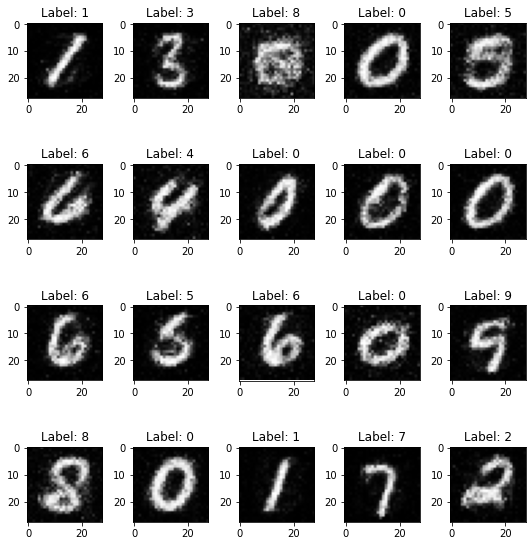

In [13]:
model.diagram(y_test)